#         Assignment 3 - Haoran Wei

### Import part

In [1]:
import glob
import unicodedata
import string
import re
import codecs 
import unidecode
import torch
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

##  Classification Using Character-Level Recurrent Neural Networks

### Preparing Data

In [2]:
all_train_filenames = glob.glob('train/*.txt')
all_val_filenames = glob.glob('val/*.txt')
print(all_train_filenames)
print(all_val_filenames)

['train/in.txt', 'train/pk.txt', 'train/fr.txt', 'train/af.txt', 'train/cn.txt', 'train/za.txt', 'train/fi.txt', 'train/ir.txt', 'train/de.txt']
['val/in.txt', 'val/pk.txt', 'val/fr.txt', 'val/af.txt', 'val/cn.txt', 'val/za.txt', 'val/fi.txt', 'val/ir.txt', 'val/de.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
category_lines_val = {}
all_train_categories = []
all_val_categories = []


# Read a file and split into lines
def readLines(filename):
    ascii_vocab = list()
    lines = codecs.open(filename,"r",encoding="utf-8",errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_train_filenames:
    print(filename)
    category = filename.split('/')[-1].split('.')[0]
    all_train_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines

n_categories = len(all_train_categories)
print('n_categories =', n_categories)
for filename in all_val_filenames:
    print(filename)
    category = filename.split('/')[-1].split('.')[0]
    all_val_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines
n_categories_val = len(all_val_categories)
print('n_categories_val =', n_categories_val)

train/in.txt
train/pk.txt
train/fr.txt
train/af.txt
train/cn.txt
train/za.txt
train/fi.txt
train/ir.txt
train/de.txt
n_categories = 9
val/in.txt
val/pk.txt
val/fr.txt
val/af.txt
val/cn.txt
val/za.txt
val/fi.txt
val/ir.txt
val/de.txt
n_categories_val = 9


### Names to tensors

In [5]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

Counts the number of lines for all validation files

In [6]:
counts = 0
for category in all_val_categories:
    for line in category_lines_val.get(category):
        counts+=1
print(counts)

900


### Creating the Network

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
#         hidden =  F.relu(self.i2h(combined))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

### Manually testing the network

In [29]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### Preparing for Training

In [9]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_train_categories[category_i], category_i

In [10]:
def random_training_pair(all_categories,category_lines):                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

In [11]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [12]:
def showloss(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
    return loss.item()

In [30]:
n_epochs = 100000
print_every = 5000
plot_every = 1000
criterion = nn.NLLLoss() # set up loss function
learning_rate = 0.0008 # If you set this too high, it might explode. If too low, it might not learn

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate )
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max = (n_epochs // 9) + 1)

In [14]:
len(category_lines_train)

9

In [31]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Keep track of losses for plotting
current_loss = 0
current_val = 0
all_losses = []
val_losses = []

start = time.time()

for epoch in range(1, n_epochs + 1):
#     scheduler.step(epoch)
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair(all_train_categories,category_lines_train)
    category_val, line_val, category_tensor_val, line_tensor_val = random_training_pair(all_val_categories,category_lines_val)
    output, loss = train(category_tensor, line_tensor)
    val_loss = showloss(category_tensor_val,line_tensor_val)
    current_loss += loss
    current_val += val_loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        val_losses.append(current_val / plot_every)
        current_loss = 0
        current_val = 0

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 21s) 2.0892 kozakyalisi / pk ✗ (za)
10000 10% (0m 46s) 2.1864 maymandchina / za ✗ (af)
15000 15% (1m 2s) 2.1413 birdsboro / fi ✗ (ir)
20000 20% (1m 19s) 2.0533 hosayn omar / ir ✗ (af)
25000 25% (1m 38s) 2.2811 demeni / cn ✗ (de)
30000 30% (1m 58s) 2.2893 frano / in ✗ (fr)
35000 35% (2m 14s) 1.9643 choqa qazan / af ✗ (za)
40000 40% (2m 31s) 0.9874 saintbertranddecomminges / fr ✓
45000 45% (2m 47s) 1.3309 faizmukhammedkarez / af ✓
50000 50% (3m 4s) 1.4527 finikravi / cn ✗ (in)
55000 55% (3m 21s) 1.5183 gosberg / de ✓
60000 60% (3m 37s) 1.2815 chargeylesgray / fr ✓
65000 65% (3m 55s) 2.2042 kuz bengaser / za ✗ (af)
70000 70% (4m 11s) 3.7972 kafr as safatiwah / af ✗ (fr)
75000 75% (4m 28s) 0.6584 bratulestifedeleseni / de ✓
80000 80% (4m 45s) 2.5033 springu muiza / in ✗ (za)
85000 85% (5m 1s) 1.2342 ayinwofi / fi ✓
90000 90% (5m 17s) 0.8316 darongjiang / cn ✓
95000 95% (5m 33s) 2.5654 graisbach / ir ✗ (de)
100000 100% (5m 50s) 0.8735 lur kalay / af ✓


### Result Plotting

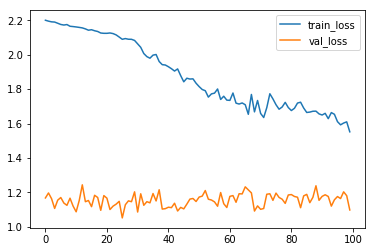

In [32]:
plt.figure()
plt.plot(all_losses, label= "train_loss")
plt.plot(val_losses, label= "val_loss")
plt.legend(loc='upper right')

### Evaluating the result

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


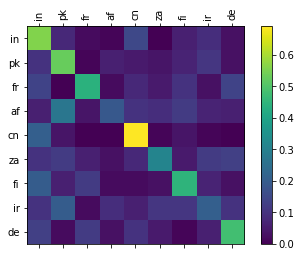

macro Accuracy: 0.428889
micro Accuracy: 0.428889


In [33]:
# Keep track of correct guesses in a confusion matrix

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

confusion = torch.zeros(n_categories, n_categories)
n_confusion = counts
# Go through a bunch of examples and record which are correctly guessed
for category in all_val_categories:
    for line in category_lines_val.get(category):
        category_tensor = Variable(torch.LongTensor(all_val_categories.index(category)))
        line_tensor = Variable(line_to_tensor(line))
        output = evaluate(line_tensor)
        guess, guess_i = category_from_output(output)
        category_i = all_val_categories.index(category)
#     category_i = all_train_categories.index(category)
        confusion[category_i][guess_i] += 1
micro_confusion = confusion.clone()
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + all_val_categories, rotation=90)
# ax.set_xticklabels([''] + all_train_categories, rotation=90)
ax.set_yticklabels([''] + all_val_categories)
# ax.set_yticklabels([''] + all_train_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
acc = 0
for i in range(confusion.shape[0]):
    acc+= confusion[i][i]
macro_acc = acc/confusion.shape[0]
print("macro Accuracy: %f"%macro_acc)
acc = 0
for i in range(micro_confusion.shape[0]):
    acc+= micro_confusion[i][i]
micro_acc = acc/n_confusion
print("micro Accuracy: %f"%micro_acc)


### Changing learning rate

In [18]:
learning_rates = [0.002, 0.001, 0.0006, 0.0004, 0.0002]
train_losses = [[], [], [], [], []]
val_losses = [[], [], [], [], [], []]
for i in range(len(learning_rates)):
    rnn_lr = RNN(n_letters, n_hidden, n_categories)
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rates[i])
    for epoch in range(1, n_epochs + 1):
        #     scheduler.step(epoch)
        # Get a random training input and target
        category, line, category_tensor, line_tensor = random_training_pair(
            all_train_categories, category_lines_train)
        category_val, line_val, category_tensor_val, line_tensor_val = random_training_pair(
            all_val_categories, category_lines_val)
        output, loss = train(category_tensor, line_tensor)
        val_loss = showloss(category_tensor_val, line_tensor_val)
        current_loss += loss
        current_val += val_loss

        # Print epoch number, loss, name and guess
        if epoch % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch /
                                                    n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
        if epoch % plot_every == 0:
            train_losses[i].append(current_loss / plot_every)
            val_losses[i].append(current_val / plot_every)
            current_loss = 0
            current_val = 0

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (5m 28s) 2.1452 beyte fiay / af ✗ (ir)
10000 10% (5m 42s) 1.3917 sazava / za ✓
15000 15% (5m 56s) 2.1024 zablaticko / fi ✗ (za)
20000 20% (6m 10s) 1.3069 chahar dehi / pk ✗ (af)
25000 25% (6m 24s) 0.5662 sakazau / za ✓
30000 30% (6m 44s) 0.8811 el redentor / de ✓
35000 35% (7m 1s) 0.8700 szakury / za ✓
40000 40% (7m 17s) 0.2084 yelizarovskaya / za ✓
45000 45% (7m 36s) 1.5462 madetkoski / fi ✓
50000 50% (7m 52s) 0.6926 zasluchchya / za ✓
55000 55% (8m 12s) 2.1689 el haza del riego / de ✗ (za)
60000 60% (8m 30s) 2.6166 kraljevec kupinecki / fi ✗ (in)
65000 65% (8m 46s) 0.9498 khewas / pk ✓
70000 70% (9m 1s) 0.5087 vurgarkalay / af ✓
75000 75% (9m 18s) 0.9311 kaurlanwala / pk ✓
80000 80% (9m 40s) 1.6081 hundshausen / cn ✗ (de)
85000 85% (10m 2s) 1.9363 nawaikhalifa hosaynzad / af ✗ (za)
90000 90% (10m 22s) 0.2676 lomza stara / za ✓
95000 95% (10m 42s) 4.0550 baba ramazan / za ✗ (ir)
100000 100% (11m 3s) 3.4075 nejey / fr ✗ (ir)
5000 5% (11m 24s) 0.9875 andahivozaky / za ✓
10000 10

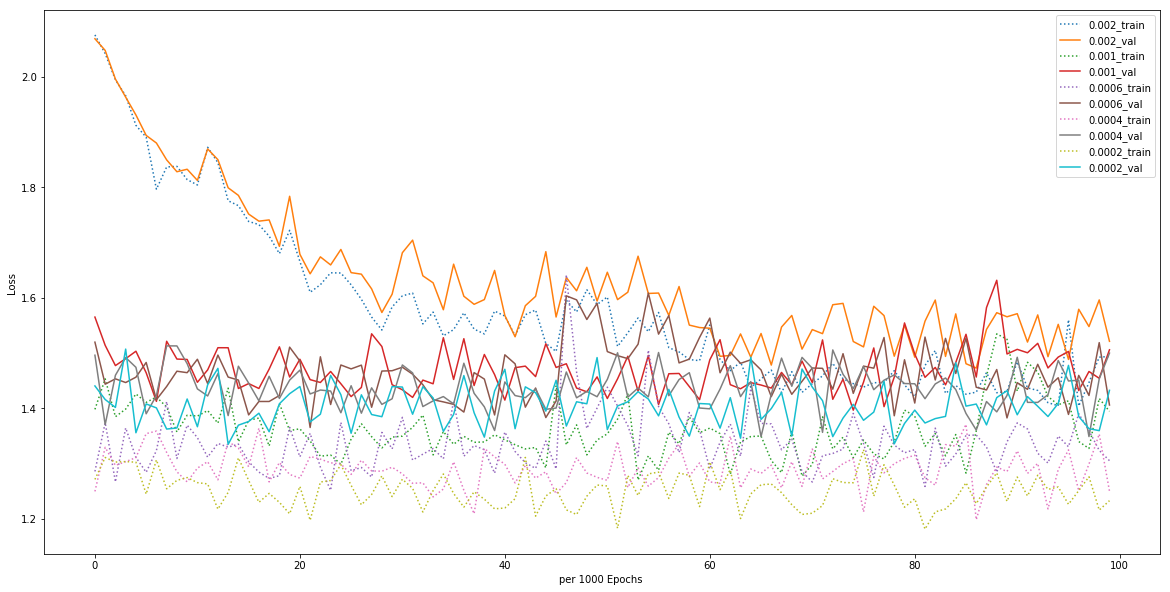

In [19]:
plt.figure(figsize=(20,10),)
for i in range(len(learning_rates)):
    plt.plot(train_losses[i], label= str(learning_rates[i])+"_train",linestyle=":")
    plt.plot(val_losses[i], label= str(learning_rates[i])+"_val")
# plt.plot(train_losses[0], label= "train_loss")
# plt.plot(val_losses[0], label= "val_loss")
plt.ylabel('Loss')
plt.xlabel('per 1000 Epochs ')
plt.legend(loc='upper right')

### Network improvement

In [20]:
# tuning parameters
N_hidden = 128

In [21]:
# define a different RNN model
class nRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(nRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h2 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden1 =  torch.relu(self.i2h1(combined))
        hidden2 = torch.relu(self.i2h2(combined))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden2

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [22]:
ip_rnn = nRNN(n_letters, N_hidden, n_categories)

In [23]:
criterion = nn.NLLLoss() # set up loss function
LR = 0.0002 # If you set this too high, it might explode. If too low, it might not learn

# optimizer = torch.optim.Adam(ip_rnn.parameters(), lr=LR, betas=(0.9, 0.999) )
optimizer = torch.optim.Adam(ip_rnn.parameters(),lr = LR)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max = (n_epochs // 9) + 1)

In [24]:
def train_nRNN(category_tensor, line_tensor):
    ip_rnn.zero_grad()
    hidden = ip_rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = ip_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [25]:
def showloss(category_tensor, line_tensor):
    with torch.no_grad():
        hidden = ip_rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = ip_rnn(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
    return loss.item()

In [26]:
current_loss = 0
current_val = 0
all_losses = []
val_losses = []

start = time.time()

for epoch in range(1, n_epochs + 1):
#     scheduler.step(epoch)
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair(all_train_categories,category_lines_train)
    category_val, line_val, category_tensor_val, line_tensor_val = random_training_pair(all_val_categories,category_lines_val)
    output, loss = train_nRNN(category_tensor, line_tensor)
    val_loss = showloss(category_tensor_val,line_tensor_val)
    current_loss += loss
    current_val += val_loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        val_losses.append(current_val / plot_every)
        current_loss = 0
        current_val = 0

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 22s) 2.0885 ovitsby / in ✗ (fi)
10000 10% (0m 46s) 1.9790 holzhausenexternsteine / in ✗ (de)
15000 15% (1m 10s) 1.0495 phulbari gazaria / za ✓
20000 20% (1m 33s) 0.7910 corral de bru / de ✓
25000 25% (1m 59s) 0.3838 antafiana / fi ✓
30000 30% (2m 23s) 0.1991 manzhangzi / cn ✓
35000 35% (2m 51s) 0.9032 gurchak / af ✓
40000 40% (3m 15s) 0.8851 kundalshai / pk ✓
45000 45% (3m 37s) 0.5112 ningguantun / in ✓
50000 50% (3m 58s) 0.1813 fila alta / fi ✓
55000 55% (4m 18s) 0.4780 ravna del / de ✓
60000 60% (4m 38s) 0.2625 mbanza uau / za ✓
65000 65% (5m 2s) 0.0089 shiqiancun / cn ✓
70000 70% (5m 22s) 1.3021 ardzulikipa'in / ir ✗ (in)
75000 75% (5m 43s) 1.7818 paimpol / pk ✗ (fr)
80000 80% (6m 6s) 0.6557 sommeron / fr ✓
85000 85% (6m 28s) 1.0750 kuchak gukcheh / af ✗ (ir)
90000 90% (6m 48s) 1.6469 lietsamaa / af ✗ (fi)
95000 95% (7m 8s) 0.3065 galuzan / za ✓
100000 100% (7m 29s) 1.0544 leleh kah / af ✗ (ir)


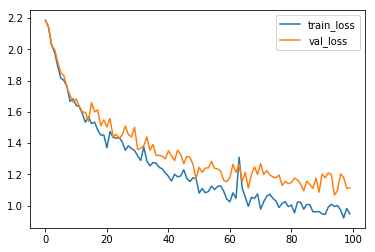

In [27]:
plt.figure()
plt.plot(all_losses, label= "train_loss")
plt.plot(val_losses, label= "val_loss")
plt.legend(loc='upper right')

/Users/weihaoran/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


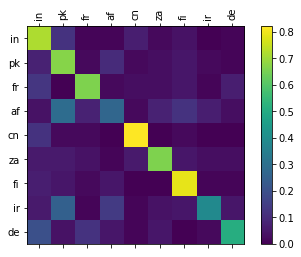

macro Accuracy: 0.610000
micro Accuracy: 0.610000


In [28]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = counts
# Go through a bunch of examples and record which are correctly guessed
for category in all_val_categories:
    for line in category_lines_val.get(category):
        category_tensor = Variable(torch.LongTensor(all_val_categories.index(category)))
        line_tensor = Variable(line_to_tensor(line))
        hidden = ip_rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = ip_rnn(line_tensor[i], hidden)
        
        guess, guess_i = category_from_output(output)
        category_i = all_val_categories.index(category)
        confusion[category_i][guess_i] += 1
micro_confusion = confusion.clone()
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + all_val_categories, rotation=90)
# ax.set_xticklabels([''] + all_train_categories, rotation=90)
ax.set_yticklabels([''] + all_val_categories)
# ax.set_yticklabels([''] + all_train_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
acc = 0
for i in range(confusion.shape[0]):
    acc+= confusion[i][i]
macro_acc = acc/confusion.shape[0]
print("macro Accuracy: %f"%macro_acc)
acc = 0
for i in range(micro_confusion.shape[0]):
    acc+= micro_confusion[i][i]
micro_acc = acc/n_confusion
print("micro Accuracy: %f"%micro_acc)
